# **Método dos Mínimos Quadrados**
---
<ul>
  <li><a href="#scrollTo=6T7Gy-Docn5C&uniqifier=1">Mínimos Quadrados</a>
  </li>
  <ul>
      <li><a href="#Introdução">Introdução</a></li>
    <li><a href="#Decorator-para-medir-tempo">Funções comuns</a></li>
    <li>Aproximação Polinomial
      <ul>
          <li><a href="#Caso-Contínuo">Caso Contínuo</a></li>
          <li><a href="#Caso-Discreto">Caso Discreto</a></li>
      </ul>
    </li>
    <li>Aplicações</li>
      <ul>
          <li><a href="#Caso-Contínuo-(Aproximação-de-funções-mais-complexas-para-funções-mais-simples)">Caso Contínuo</a></li>
          <li><a href="#Caso-Discreto-(Aproximação-de-pares-de-pontos-para-uma-função)">Caso Discreto</a></li>
      </ul>
    <li>Comparações</li>
      <ul>
          <li><a href="#Tempo-do-Caso-Contínuo">Caso Contínuo</a></li>
          <li><a href="#Tempo-do-Caso-Discreto">Caso Discreto</a></li>
      </ul>
  </ul>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math as m
import timeit

## **Introdução**

Dado $f$:

Seja $f$ uma função qualquer, e $V$ um espaço de funções conhecidas, gerado pelas funções {$\varphi_0$ , $\dots$ , $\varphi_n$}.

Queremos encontrar uma combinação de funções conhecidas $F$, que aproxime-se de $f$, ou seja, que minimize a distância entre $f$ e $F$.

Sendo $F = \alpha_0\varphi_0 + \dots + \alpha_n\varphi_n$.

Para encontrar $F$, precisamos resolver o seguinte sistema:

$\begin{bmatrix}
  [\varphi_0, \varphi_0] & 
    \dots & 
    [\varphi_0, \varphi_n] \\[1ex]
  \vdots & 
     & 
    \vdots \\[1ex]
  [\varphi_n, \varphi_0] & 
    \dots & 
    [\varphi_n, \varphi_n]
\end{bmatrix}$
$\begin{bmatrix}
  \alpha_0 \\[1ex]
  \vdots \\[1ex]
  \alpha_n
\end{bmatrix}$ = 
$\begin{bmatrix}
  [f, \varphi_0] \\[1ex]
  \vdots \\[1ex]
  [f, \varphi_n]
\end{bmatrix}$

Para encontrar $F$ vamos utilizar a Aproximação Polinomial.

---

## Decorator para medir tempo

In [2]:
import time

# Decorator timeit
# Retorna o tempo de excução da função
# Não modifica a função.
# Para mais informações sobre decorators e timeit:
# https://medium.com/pythonhive/python-decorator-to-measure-the-execution-time-of-methods-fa04cb6bb36d
def timeit(method):
    def timed(*args, **kw):
        ts = time.time();
        result = method(*args, **kw);

        te = time.time();

        # Armazenar resultado
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__);
            kw['log_time'][name].append((te - ts) * 1000);
        else:
            print("%r  %2.5f ms" % (method.__name__, (te - ts) * 1000));
        return result
    return timed

In [3]:
log_data = {
    'continuous' : [],
    'discrete' : []
}

---

## Aproximação Polinomial

### Caso Contínuo

No caso discreto, queremos aproximar a função $f$ de um polinômio $P_m$:

$f(x) \approx P_m(x) = \alpha_0 + \alpha_1x + \dots + \alpha_mx^m$

Como sabemos que $B$ = {$1, x, x^2, \dots, x^m$} é base de $P_m$, temos que resolver os seguinte sistema linear para encontrar $P_m(X)$:

$\begin{bmatrix}
  [1, 1] &
    [1, x] &
    \dots & 
    [1, x^m] \\[1ex]
  [x, 1] &
    [x, x] &
    \dots & 
    [x, x^m] \\[1ex]
  \vdots & 
    \vdots &
    \dots &
    \vdots \\[1ex]
  [x^m, 1] &
    [x^m, x] &
    \dots & 
    [x^m, x^m]
\end{bmatrix}$
$\begin{bmatrix}
  \alpha_0 \\[1ex]
  \alpha_1 \\[1ex]
  \vdots \\[1ex]
  \alpha_m
\end{bmatrix}$ = 
$\begin{bmatrix}
  [1, f] \\[1ex]
  [x, f] \\[1ex]
  \vdots \\[1ex]
  [x^m, f]
\end{bmatrix}$

Sendo $[a, b]$ = $\int_{0}^{1}a(x)b(x)dx$

In [4]:
def Cholesky(M):
    M_copy = np.tril(M)
    row = M.shape[0]
    
    for x in range(row):
        for y in range(x+1):
            sum_ = 0
            for z in range(y):
                sum_ = sum_ + M_copy[x][z]*M_copy[y][z]
            if(x == y):
                M_copy[x][y] = m.sqrt(M_copy[x][y]-sum_)
            else:
                M_copy[x][y] = (1/M_copy[y][y]*(M_copy[x][y]-sum_))
    return M_copy

def lower(L, N):
    row = L.shape[0]
    z = np.zeros(row)
    
    for x in range(row):
        z[x] = (N[x]-L[x,0:x].dot(z[0:x]))/L[x,x]
    
    return z

def upper(U, z):
    row = U.shape[0]
    alpha = np.zeros(row)
    
    for x in range(row-1, -1, -1):
        alpha[x] = (z[x]-U[x,x+1:row].dot(alpha[x+1:row]))/U[x,x]
        
    return alpha

#M * alpha = N
@timeit
def continuous(M, N, **kwards):
    #Fatoração de Cholesky de M
    new_M = Cholesky(M)
    
    #Calculando alpha
    z = lower(new_M, N)
    alpha = upper(np.transpose(new_M), z)
    
    return alpha

### Caso Discreto

No caso discreto, conhecemos (n+1) pares de pontos que pertencem a função $f$, então consideramos:

$y_i = f(x_i)$

Sendo $(x_i, y_i)$ os pontos conhecidos, e i = 0, 1, ..., n-1, n.

Assim como no caso contínuo, queremos aproximar a função $f$ de um polinômio $P_m$:

$f(x) \approx P_m(x) = \alpha_0 + \alpha_1x + \dots + \alpha_mx^m$, m < n


Sabendo que:

$P_m(x_0) = \alpha_0 + \alpha_1x_0 + \alpha_2x_0^2 + \dots + \alpha_mx_0^m$

$P_m(x_1) = \alpha_0 + \alpha_1x_1 + \alpha_2x_1^2 + \dots + \alpha_mx_1^m$

$\vdots$

$P_m(x_0) = \alpha_0 + \alpha_1x_0 + \alpha_2x_0^2 + \dots + \alpha_mx_0^m$

e supondo que $p = (P_m(x_0), P_m(x_1), \dots, P_m(x_n))$

Temos que:

$p = \alpha_0$
$\begin{bmatrix}
  1 \\[1ex]
  1 \\[1ex]
  \vdots \\[1ex]
  1
\end{bmatrix}$ +
 $\alpha_1$
$\begin{bmatrix}
  x_0 \\[1ex]
  x_1 \\[1ex]
  \vdots \\[1ex]
  x_n
\end{bmatrix}$ +
 $\alpha_2$
$\begin{bmatrix}
  x_0^2 \\[1ex]
  x_1^2 \\[1ex]
  \vdots \\[1ex]
  x_n^2
\end{bmatrix}$ +
$\dots$ +
$\alpha_m$
$\begin{bmatrix}
  x_0^m \\[1ex]
  x_1^m \\[1ex]
  \vdots \\[1ex]
  x_n^m
\end{bmatrix}$

Supondo que $Y = (y_0, y_1, \dots, y_n)$

E sabendo que o conjunto $U = (u_0, u_1, \dots, u_n)$ é base. Sendo:

$u_0 = [1, 1, \dots, 1]$

$u_1 = [x_0, x_1, \dots, x_n]$

$u_2 = [x_0^2, x_1^2, \dots, x_n^2]$

$\vdots$

$u_m = [x_0^m, x_1^m, \dots, x_n^m]$

Temos que resolver o seguinte sistema linear para encontrar $P_m(x)$:

$\begin{bmatrix}
  [u_0, u_0] &
    [u_0, u_1] &
    \dots & 
    [u_0, u_m] \\[1ex]
  [u_1, u_0] &
    [u_1, u_1] &
    \dots & 
    [u_1, u_m] \\[1ex]
  \vdots & 
    \vdots &
    \dots &
    \vdots \\[1ex]
  [u_m, u_0] &
    [u_m, u_1] &
    \dots & 
    [u_m, u_m]
\end{bmatrix}$
$\begin{bmatrix}
  \alpha_0 \\[1ex]
  \alpha_1 \\[1ex]
  \vdots \\[1ex]
  \alpha_m
\end{bmatrix}$ = 
$\begin{bmatrix}
  [u_0, Y] \\[1ex]
  [u_1, Y] \\[1ex]
  \vdots \\[1ex]
  [u_m, Y]
\end{bmatrix}$

Sendo $[a, b]$ = $\sum_{k=0}^{n}a_kb_k$

Esse sistema pode ser reescrito da seguinte forma:

$\begin{bmatrix}
  1 &
    1 &
    \dots & 
    1 \\[1ex]
  x_0 &
    x_1 &
    \dots & 
    x_n \\[1ex]
  \vdots & 
    \vdots &
    \dots &
    \vdots \\[1ex]
  x_0^m &
    x_1^m &
    \dots & 
    x_n^m
\end{bmatrix}$
$\begin{bmatrix}
  1 &
    x_0 &
    \dots & 
    x_0^m \\[1ex]
  1 &
    x_1 &
    \dots & 
    x_1^m \\[1ex]
  \vdots & 
    \vdots &
    \dots &
    \vdots \\[1ex]
  1 &
    x_n &
    \dots & 
    x_n^m \\[1ex]
\end{bmatrix}$
$\begin{bmatrix}
  \alpha_0 \\[1ex]
  \alpha_1 \\[1ex]
  \vdots \\[1ex]
  \alpha_m
\end{bmatrix}$ = 
$\begin{bmatrix}
  1 &
    1 &
    \dots & 
    1 \\[1ex]
  x_0 &
    x_1 &
    \dots & 
    x_n \\[1ex]
  \vdots & 
    \vdots &
    \dots &
    \vdots \\[1ex]
  x_0^m &
    x_1^m &
    \dots & 
    x_n^m
\end{bmatrix}$
$\begin{bmatrix}
  y_0 \\[1ex]
  y_1 \\[1ex]
  \vdots \\[1ex]
  y_m
\end{bmatrix}$

Ou seja:

$M^TM\alpha = M^TY \Rightarrow \alpha = (M^TM)^{-1}M^TY$

In [5]:
def in_continuous(M, N):
    #Fatoração de Cholesky de M
    new_M = Cholesky(M)
    
    #Calculando alpha
    z = lower(new_M, N)
    alpha = upper(np.transpose(new_M), z)
    
    return alpha

# x e y: vetores de dados
# k = grau do Polinômio
@timeit
def discrete(x, y, k, **kwards):
    M = np.vander(x, k).astype('double')
    A = np.transpose(M).dot(M).astype('double')
    B = np.transpose(M).dot(y).astype('double')
    alpha = in_continuous(A, B)
    
    return alpha

---

## Aplicações

### Caso Contínuo (Aproximação de funções mais complexas para funções mais simples)

Utilizando como exemplo a função $f(x) = 4x^3, 0 < x < 1$, e querendo aproximá-la do Polinômio $P_2(x) = \alpha_0 + \alpha_1x$

Temos o seguinte sistema linear para resolver:

$\begin{bmatrix}
  1 &
    \frac{1}{2} \\[1ex]
  \frac{1}{2} &
    \frac{1}{3}
\end{bmatrix}$
$\begin{bmatrix}
  \alpha_0 \\[1ex]
  \alpha_1
\end{bmatrix}$ = 
$\begin{bmatrix}
  1 \\[1ex]
  \frac{4}{5}
\end{bmatrix}$

Queremos encontrar $F(x) = \alpha_0 + \alpha_1x$

In [6]:
M = np.array([[    1.0, 1.0/2.0],    
              [1.0/2.0, 1.0/3.0]], dtype='double')
N = np.array( [    1.0, 4.0/5.0])

alpha = continuous(M, N, log_time=log_data)
print("Tempo de Execução: ", log_data['continuous'][0], "s", sep = ' ')

print("F(x) = ", ("%.1f"%alpha[0]), " + ", ("%.1f"%alpha[1]), "x", sep='')

Tempo de Execução:  0.18548965454101562 s
F(x) = -0.8 + 3.6x


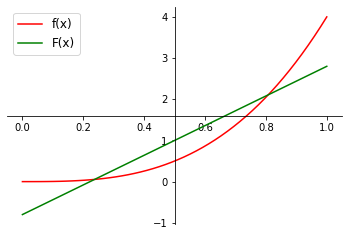

In [7]:
x = np.linspace(0,1)
f = 4*(x**3)
F = -0.8 + 3.6*x

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.plot(x, f, color='r', label='f(x)');
ax.plot(x, F, color='g', label='F(x)');
plt.legend(fontsize='large')

plt.show()

No gráfico acima podemos ver a função f(x) em vermelho, e F(x) em verde

---

Podemos também utilizar como exemplo a função $g(x) = \cos(\pi x)$, com o objetivo de aproximá-la do Polinômio $P_3 = \alpha_0 + \alpha_1x + \alpha_2x^2$

$\begin{bmatrix}
  1 &
    \frac{1}{2} &
    \frac{1}{3} \\[1ex]
  \frac{1}{2} &
    \frac{1}{3} &
    \frac{1}{4} \\[1ex]
  \frac{1}{3} &
    \frac{1}{4} &
    \frac{1}{5}  
\end{bmatrix}$
$\begin{bmatrix}
  \alpha_0 \\[1ex]
  \alpha_1 \\[1ex]
  \alpha_2
\end{bmatrix}$ = 
$\begin{bmatrix}
  0 \\[1ex]
   \frac{-2}{\pi^2} \\[1ex]
   \frac{-2}{\pi^2}
\end{bmatrix}$

Queremos encontrar $G(x) = \alpha_0 + \alpha_1x + \alpha_2x^2$

In [8]:
M = np.array([[    1.0, 1.0/2.0, 1.0/3.0],  
              [1.0/2.0, 1.0/3.0, 1.0/4.0],
              [1.0/3.0, 1.0/4.0, 1.0/5.0]], dtype='double')
N = np.array( [    0.0, -2/(m.pi**2), -2/(m.pi**2)])

alpha = continuous(M, N, log_time=log_data)
print("Tempo de Execução: ", log_data['continuous'][1], "s", sep = ' ')
print("G(x) = ", ("%.4f"%alpha[0]), " + ", ("%.4f"%alpha[1]), "x", " + ", ("%.4f"%alpha[2]), "x²" , sep='')

Tempo de Execução:  0.4856586456298828 s
G(x) = 1.2159 + -2.4317x + 0.0000x²


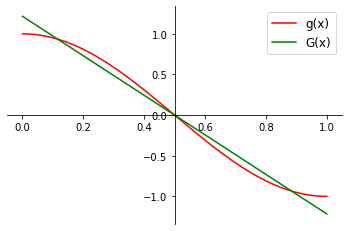

In [9]:
x = np.linspace(0,1)
g = np.cos(m.pi*x)
G = 1.2159 -2.4317*x

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.plot(x, g, color='r', label='g(x)');
ax.plot(x, G, color='g', label='G(x)');
plt.legend(fontsize='large')

plt.show()

No gráfico acima podemos ver a função g(x) em vermelho, e G(x) em verde

---

### Caso Discreto (Aproximação de pares de pontos para uma função)

Utilizando como o exemplo os dados de infectados pela Covid-19, encontrados na pasta assets. Vamos tentar encontrar uma função que se aproxime das coordendas dos dados.

Tempo de Execução:  0.3521442413330078 s


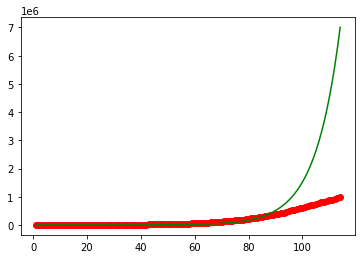

In [10]:
infectados = np.genfromtxt(fname='assets/casosacumuladosbrasilatuaizado.txt')
size = infectados.shape[0]
dias = np.zeros(size, dtype='int')
for x in range(size):
    dias[x] = x+1
    
#Aproximando para uma função ab^x
alpha = discrete(dias, np.log(infectados), 2, log_time=log_data)
print("Tempo de Execução: ", log_data['discrete'][0], "s", sep = ' ')

b = np.exp(alpha[0])
a = np.exp(alpha[1])

#f(x) = a(b^x)
f = lambda x: a*(b**x)
plt.plot(dias, infectados, 'ro')
plt.plot(dias, f(dias), 'g')
plt.show()

Acima podemos ver a comparação da função f(x) de verde, com as coordenadas dos dados, em vermelho.

Podemos perceber que a partir aproximadamente do dia 90, f(x) começa a se afastar das coordenadas dos dados.

---

## Comparações

### Tempo do Caso Contínuo 

In [11]:
@timeit
def np_continuous(M, N, **kwards):
    alpha = np.linalg.solve(M, N)
    
    return alpha

In [12]:
#Comparação da Aplicação 1:
log_data = {
    'continuous' : [],
    'np_continuous' : []
}

M = np.array([[    1.0, 1.0/2.0],    
              [1.0/2.0, 1.0/3.0]], dtype='double')
N = np.array( [    1.0, 4.0/5.0])

for x in range(10):
    alpha = continuous(M, N, log_time=log_data)
    alpha = np_continuous(M, N, log_time=log_data)
print("Tempo Média da Função Criada: ", np.mean(log_data['continuous']))
print("Tempo Média da Função Pronta: ", np.mean(log_data['np_continuous']))

Tempo Média da Função Criada:  0.12021064758300781
Tempo Média da Função Pronta:  0.04153251647949219


In [13]:
#Comparação da Aplicação 2:
log_data = {
    'continuous' : [],
    'np_continuous' : []
}

M = np.array([[    1.0, 1.0/2.0, 1.0/3.0],  
              [1.0/2.0, 1.0/3.0, 1.0/4.0],
              [1.0/3.0, 1.0/4.0, 1.0/5.0]], dtype='double')
N = np.array( [    0.0, -2/(m.pi**2), -2/(m.pi**2)])

for x in range(10):
    alpha = continuous(M, N, log_time=log_data)
    alpha = np_continuous(M, N, log_time=log_data)
print("Tempo Média da Função Criada: ", np.mean(log_data['continuous']))
print("Tempo Média da Função Pronta: ", np.mean(log_data['np_continuous']))

Tempo Média da Função Criada:  0.37822723388671875
Tempo Média da Função Pronta:  0.03840923309326172


Pela comparação de tempo acima, podemos perceber que a função pronta da biblioteca numpy de Método de Mínimos Quadrados de Caso Contínuo é executada em menos tempo que a função criada.

### Tempo do Caso Discreto

In [14]:
@timeit
def np_discrete(x, y, **kwards):
    A = np.transpose(np.vstack([y, np.ones(len(y))]))
    alpha = np.linalg.lstsq(A, np.log(y), rcond=None)[0];
    
    return alpha

In [15]:
#Comparação da Aplicação
log_data = {
    'discrete' : [],
    'np_discrete' : []
}

infectados = np.genfromtxt(fname='assets/casosacumuladosbrasilatuaizado.txt')
size = infectados.shape[0]
dias = np.zeros(size, dtype='int')
for x in range(size):
    dias[x] = x+1
    
for x in range(10):
    alpha = discrete(dias, np.log(infectados), 2, log_time=log_data)
    alpha = np_discrete(dias, infectados, log_time=log_data)
print("Tempo Média da Função Criada: ", np.mean(log_data['discrete']))
print("Tempo Média da Função Pronta: ", np.mean(log_data['np_discrete']))

Tempo Média da Função Criada:  0.24881362915039062
Tempo Média da Função Pronta:  0.1514434814453125


No caso Discreto, novamente podemos ver que a Função pronta do numpy é mais rápida que a Função Criada.